# Projet 4: maintenance

Ce notebook présente une simulation destiner à déterminer la fréquence nécessaire de mise à jour de la segmentation des clients.

En effet, les données RFM d'un client évoluent au cours du temps et de nouveaux clients s'ajoutent à la base de données donc il faut régulièrement mettre à jour le modèle de clustering.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn import metrics
import datetime

# Simulation

L'idée est la suivante. A un instant T0 on réalise un clustering de notre jeu de données X0: chaque client de X0 est rangé dans un cluster. A un instant ultérieur T1 nous disposons d'un jeu de données X1 qui contient tous les clients de X0 (avec des données RFM différentes) ainsi que de nouveaux clients. La question qui se pose alors est: quelle proportion de client de X0 change de cluster lorsque l'on refait un clustering, cette fois-ci sur X1?
S'il y a trop de client qui sont assignés à un nouveau cluster alors il faut entraîner un nouveau modèle.

Concrêtement il faut partir d'un jeu de données X0 contenant déjà suffisament de clients pour que le premier modèle ne soit pas obsolète au bout d'une semaine, et qui s'arrête à une date suffisamment éloignée de la date de fin de notre jeu de données complet pour pouvoir faire plusieurs tests.

Pour mesurer les changements au sein des clusters on utilisera l'indice de rang ajusté (ARI).

Le modèle de clustering qui a été retenu est un modèle k-means à 4 clusters sur les trois variables RFM.

On part du fichier "olist_merge_data" et non "data_rfm" car on veut simuler différentes dates d'exécution du clustering.

In [2]:
data = pd.read_csv("olist_merge_data.csv")

In [3]:
# On convertit 'order_purchase_date' en date
data['order_purchase_date'] = pd.to_datetime(data['order_purchase_date'])

In [4]:
max_date = max(data['order_purchase_date'])
max_date

Timestamp('2018-09-03 00:00:00')

On va partir de la fin de l'année 2017, ce qui nous laissera 8 mois, et faire une simulation par pas d'une semaine pour être assez précis sur la date de maintenance.

In [5]:
delta_time = 7 # Intervalle de temps entre chaque simulation de clustering
T0 = pd.to_datetime('2017-12-31') # Date d'initialisation du modèle (premier clustering)

On écrit ensuite une fonction pour réaliser les clusterings successifs et récupérer les ARI.

In [6]:
def get_ari(delta_time, T0):
    '''
    Renvoi une liste de listes contenant trois éléments: la date de fin du jeu de données, le nombre d'intervalle de temps
    écoulés depuis l'initialisation, et l'ARI.
    
    Paramètres:
    ----------
    delta_time : intervalle de temps entre chaque nouveau clustering
    T0 : date d'initialisation de la segmentation des clients
    '''
    list_ari = [] # Liste à renvoyer par la fonction
    max_date_iter = T0 # détermine la date de fin du jeu de données
    
    # Initialisation, clustering de référence
    
    X0 = data[data['order_purchase_date']<=T0] # clients avant T0
    # Création du jeu de données RFM
    X0 = X0.groupby(['customer_unique_id'])
    X0 = X0.agg({ 
            'order_purchase_date': lambda x: (T0 - x.max()).days,
            'customer_id':'count',
            'price':'sum'}).reset_index()
    X0.columns = ['customer_unique_id', 'recent', 'frequence', 'montant']
    # Préprocessing
    std_scale = preprocessing.StandardScaler().fit(X0[['recent', 'frequence', 'montant']] )
    X0_scaled = std_scale.transform(X0[['recent', 'frequence', 'montant']] )
    # Clustering
    model = KMeans(n_clusters=4, random_state=10)
    y0_pred = model.fit_predict(X0_scaled)
    
    
    i = 0 # Compte le nombre d'intervalle delta_time écoulé
    while max_date_iter < max_date:
        max_date_iter = max_date_iter + datetime.timedelta(days=delta_time) # Nouvelle date de fin des données
        i += 1
        # Jeu de données suivant
        X = data[data['order_purchase_date']<=max_date_iter]
        # Création du jeu de données RFM suivant
        X = X.groupby(['customer_unique_id'])
        X = X.agg({
            'order_purchase_date': lambda x: (max_date_iter - x.max()).days,
            'customer_id':'count',
            'price':'sum'}).reset_index()
        X.columns = ['customer_unique_id', 'recent', 'frequence', 'montant']
        # Preprocessing
        std_scale = preprocessing.StandardScaler().fit(X[['recent', 'frequence', 'montant']])
        X_scaled = std_scale.transform(X[['recent', 'frequence', 'montant']])
        # Clustering
        model = KMeans(n_clusters=4, random_state=10)
        y_pred = model.fit_predict(X_scaled)
        X['classe'] = y_pred
        # On regarde les changements de cluster des clients qui étaient déjà présent dans X
        y1_pred = X[X['customer_unique_id'].isin(X0['customer_unique_id'].to_list())]['classe'].to_numpy()
        list_ari.append([max_date_iter, i, metrics.adjusted_rand_score(y0_pred, y1_pred)])

    return list_ari

On utilise notre fonction.

In [7]:
list_ari = get_ari(delta_time, T0)

On considère qu'une mainenance est nécessaire quand l'ARI passe en dessous de 0.8. Il suffit de lire la iste list_ari, mais on va quand même tracer un graphique pour avoir une vue d'ensemble.

In [8]:
l = [list_ari[i][2] for i in range(0, len(list_ari))] # On récupère les ARI

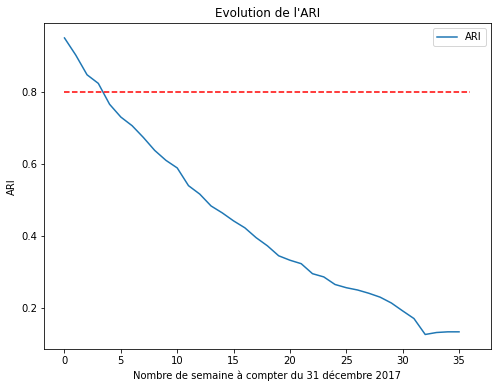

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(range(0, len(list_ari)), l, label='ARI')
plt.hlines(0.8, 0, len(list_ari), linestyles='dashed', color='red')
plt.title('Evolution de l\'ARI')
plt.ylabel('ARI')
plt.xlabel('Nombre de semaine à compter du 31 décembre 2017')
plt.legend()

In [10]:
list_ari

[[Timestamp('2018-01-07 00:00:00'), 1, 0.9483959723316472],
 [Timestamp('2018-01-14 00:00:00'), 2, 0.9009682599304223],
 [Timestamp('2018-01-21 00:00:00'), 3, 0.8464030588528345],
 [Timestamp('2018-01-28 00:00:00'), 4, 0.8225875375665868],
 [Timestamp('2018-02-04 00:00:00'), 5, 0.7646730129786837],
 [Timestamp('2018-02-11 00:00:00'), 6, 0.7292300627478069],
 [Timestamp('2018-02-18 00:00:00'), 7, 0.7052938264426751],
 [Timestamp('2018-02-25 00:00:00'), 8, 0.6726584824075195],
 [Timestamp('2018-03-04 00:00:00'), 9, 0.6369423581011245],
 [Timestamp('2018-03-11 00:00:00'), 10, 0.6093025537591936],
 [Timestamp('2018-03-18 00:00:00'), 11, 0.5883244985539904],
 [Timestamp('2018-03-25 00:00:00'), 12, 0.5392247084297619],
 [Timestamp('2018-04-01 00:00:00'), 13, 0.5158353043880439],
 [Timestamp('2018-04-08 00:00:00'), 14, 0.4830321719100401],
 [Timestamp('2018-04-15 00:00:00'), 15, 0.46371396942848814],
 [Timestamp('2018-04-22 00:00:00'), 16, 0.4416149008303884],
 [Timestamp('2018-04-29 00:00:00

Le modèle initialisé fin 2017 est valable 4 semaines. On effectue la maintenance au cours de la 5ème semaine avec un jeu de données allant jusqu'à 2018-01-28.

On refait une simulation à partir du 2018-01-28.

In [11]:
T1 = pd.to_datetime('2018-01-28')

In [12]:
list_ari = get_ari(delta_time, T1)

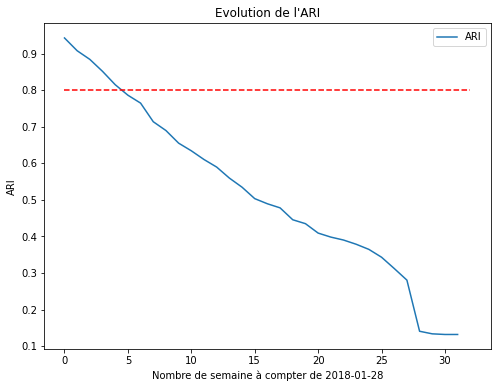

In [13]:
l = [list_ari[i][2] for i in range(0, len(list_ari))]
plt.figure(figsize=(8, 6))
plt.plot(range(0, len(list_ari)), l, label='ARI')
plt.hlines(0.8, 0, len(list_ari), linestyles='dashed', color='red')
plt.title('Evolution de l\'ARI')
plt.ylabel('ARI')
plt.xlabel('Nombre de semaine à compter de 2018-01-28')
plt.legend()

In [14]:
list_ari

[[Timestamp('2018-02-04 00:00:00'), 1, 0.9432141981750228],
 [Timestamp('2018-02-11 00:00:00'), 2, 0.9082121141995038],
 [Timestamp('2018-02-18 00:00:00'), 3, 0.884548443737459],
 [Timestamp('2018-02-25 00:00:00'), 4, 0.8518160255816983],
 [Timestamp('2018-03-04 00:00:00'), 5, 0.8153067045879653],
 [Timestamp('2018-03-11 00:00:00'), 6, 0.7865721384235167],
 [Timestamp('2018-03-18 00:00:00'), 7, 0.7649426339368145],
 [Timestamp('2018-03-25 00:00:00'), 8, 0.7140181266177322],
 [Timestamp('2018-04-01 00:00:00'), 9, 0.689893087649649],
 [Timestamp('2018-04-08 00:00:00'), 10, 0.6553755530219063],
 [Timestamp('2018-04-15 00:00:00'), 11, 0.6344785553114641],
 [Timestamp('2018-04-22 00:00:00'), 12, 0.6106296046427788],
 [Timestamp('2018-04-29 00:00:00'), 13, 0.5899070169028234],
 [Timestamp('2018-05-06 00:00:00'), 14, 0.5598248451087093],
 [Timestamp('2018-05-13 00:00:00'), 15, 0.5348734421554554],
 [Timestamp('2018-05-20 00:00:00'), 16, 0.5035763142982452],
 [Timestamp('2018-05-27 00:00:00'),

Cette fois-ci le modèle est valable 5 semaines. 

On refait une simulation à partir du 2018-03-04.

In [15]:
T2 = pd.to_datetime('2018-03-04')

In [16]:
list_ari = get_ari(delta_time, T2)

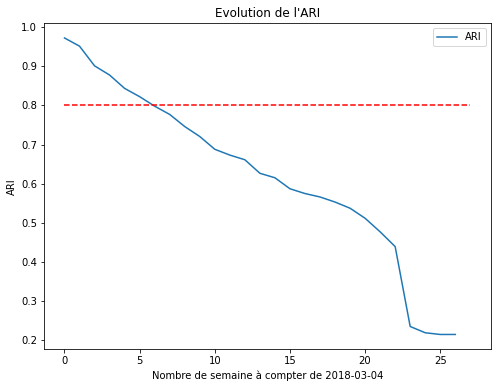

In [17]:
l = [list_ari[i][2] for i in range(0, len(list_ari))]
plt.figure(figsize=(8, 6))
plt.plot(range(0, len(list_ari)), l, label='ARI')
plt.hlines(0.8, 0, len(list_ari), linestyles='dashed', color='red')
plt.title('Evolution de l\'ARI')
plt.ylabel('ARI')
plt.xlabel('Nombre de semaine à compter de 2018-03-04')
plt.legend()

In [18]:
list_ari

[[Timestamp('2018-03-11 00:00:00'), 1, 0.972237283870087],
 [Timestamp('2018-03-18 00:00:00'), 2, 0.9512782796373436],
 [Timestamp('2018-03-25 00:00:00'), 3, 0.9009958356244944],
 [Timestamp('2018-04-01 00:00:00'), 4, 0.8774941704642676],
 [Timestamp('2018-04-08 00:00:00'), 5, 0.8433965504955232],
 [Timestamp('2018-04-15 00:00:00'), 6, 0.8222038003270538],
 [Timestamp('2018-04-22 00:00:00'), 7, 0.7979456492159887],
 [Timestamp('2018-04-29 00:00:00'), 8, 0.7768330675408077],
 [Timestamp('2018-05-06 00:00:00'), 9, 0.7459017889926293],
 [Timestamp('2018-05-13 00:00:00'), 10, 0.7204462381072226],
 [Timestamp('2018-05-20 00:00:00'), 11, 0.6877785201504888],
 [Timestamp('2018-05-27 00:00:00'), 12, 0.6730048280251076],
 [Timestamp('2018-06-03 00:00:00'), 13, 0.6610423529183779],
 [Timestamp('2018-06-10 00:00:00'), 14, 0.6264826476894533],
 [Timestamp('2018-06-17 00:00:00'), 15, 0.6150102062114005],
 [Timestamp('2018-06-24 00:00:00'), 16, 0.5869400518889596],
 [Timestamp('2018-07-01 00:00:00')

Cette fois-ci le modèle est valable 6 semaines.

On refait une simulation à partir du 2018-04-15.

In [19]:
T3 = pd.to_datetime('2018-04-15')

In [20]:
list_ari = get_ari(delta_time, T3)

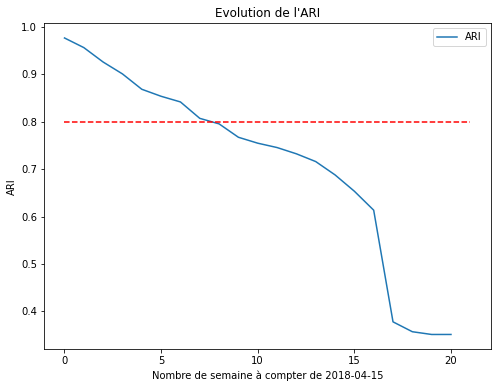

In [21]:
l = [list_ari[i][2] for i in range(0, len(list_ari))]
plt.figure(figsize=(8, 6))
plt.plot(range(0, len(list_ari)), l, label='ARI')
plt.hlines(0.8, 0, len(list_ari), linestyles='dashed', color='red')
plt.title('Evolution de l\'ARI')
plt.ylabel('ARI')
plt.xlabel('Nombre de semaine à compter de 2018-04-15')
plt.legend()

In [22]:
list_ari

[[Timestamp('2018-04-22 00:00:00'), 1, 0.9763059200072024],
 [Timestamp('2018-04-29 00:00:00'), 2, 0.9560096609240731],
 [Timestamp('2018-05-06 00:00:00'), 3, 0.9255794968236011],
 [Timestamp('2018-05-13 00:00:00'), 4, 0.9005159437196455],
 [Timestamp('2018-05-20 00:00:00'), 5, 0.8681788284262522],
 [Timestamp('2018-05-27 00:00:00'), 6, 0.8533908793734659],
 [Timestamp('2018-06-03 00:00:00'), 7, 0.8414867569876107],
 [Timestamp('2018-06-10 00:00:00'), 8, 0.806902333576507],
 [Timestamp('2018-06-17 00:00:00'), 9, 0.7952526927083508],
 [Timestamp('2018-06-24 00:00:00'), 10, 0.767013567257297],
 [Timestamp('2018-07-01 00:00:00'), 11, 0.7545456294454027],
 [Timestamp('2018-07-08 00:00:00'), 12, 0.7453622838159784],
 [Timestamp('2018-07-15 00:00:00'), 13, 0.7321588971557002],
 [Timestamp('2018-07-22 00:00:00'), 14, 0.7158241230028023],
 [Timestamp('2018-07-29 00:00:00'), 15, 0.6877453070800956],
 [Timestamp('2018-08-05 00:00:00'), 16, 0.653291626071802],
 [Timestamp('2018-08-12 00:00:00'), 

Cette fois-ci le modèle est valable 8 semaines. Le fait que le modèle est valable de plus en plus longtemps peut s'expliquer par le fait qu'on ajoute <u>en proportion</u> de moins en moins de données chaque semaine.

On refait une simulation à partir du 2018-06-10. La dernière puisque nous arrivons au mois d'août.

In [23]:
T4 = pd.to_datetime('2018-06-10')

In [24]:
list_ari = get_ari(delta_time, T4)

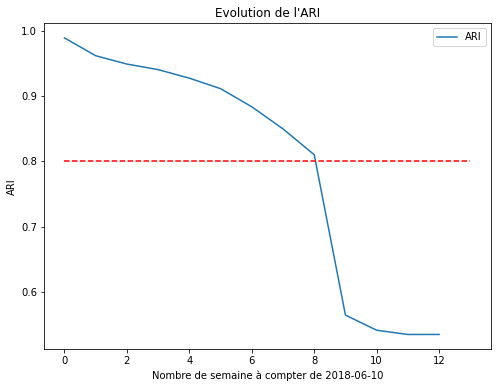

In [25]:
l = [list_ari[i][2] for i in range(0, len(list_ari))]
plt.figure(figsize=(8, 6))
plt.plot(range(0, len(list_ari)), l, label='ARI')
plt.hlines(0.8, 0, len(list_ari), linestyles='dashed', color='red')
plt.title('Evolution de l\'ARI')
plt.ylabel('ARI')
plt.xlabel('Nombre de semaine à compter de 2018-06-10')
plt.legend()

In [26]:
list_ari

[[Timestamp('2018-06-17 00:00:00'), 1, 0.9886219601779235],
 [Timestamp('2018-06-24 00:00:00'), 2, 0.9614548455166516],
 [Timestamp('2018-07-01 00:00:00'), 3, 0.9486954108276097],
 [Timestamp('2018-07-08 00:00:00'), 4, 0.9402226632142059],
 [Timestamp('2018-07-15 00:00:00'), 5, 0.9271078609108331],
 [Timestamp('2018-07-22 00:00:00'), 6, 0.9110675868636292],
 [Timestamp('2018-07-29 00:00:00'), 7, 0.8833686423172844],
 [Timestamp('2018-08-05 00:00:00'), 8, 0.8495567728098944],
 [Timestamp('2018-08-12 00:00:00'), 9, 0.8100730079569574],
 [Timestamp('2018-08-19 00:00:00'), 10, 0.5647995163301063],
 [Timestamp('2018-08-26 00:00:00'), 11, 0.5416532893543651],
 [Timestamp('2018-09-02 00:00:00'), 12, 0.5351611836215033],
 [Timestamp('2018-09-09 00:00:00'), 13, 0.5351945678519091]]

Finalement on estime que la prochaine maintenance doit avoir lieu dans 9 semaines, c'est-à-dire dans 2 mois.